In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib
import cooler

In [2]:
cooler_file = '/pollard/data/wynton/consortia/4DN/rao2014/GM12878/4DNFIXP4QG5B.mcool'
# cooler_file = '/pollard/data/wynton/consortia/4DN/krietenstein2020/H1-hESC/4DNFI9GMP2J8.mcool'

In [3]:
# load cooler, obtain bin table
resolution = 50000
c = cooler.Cooler(cooler_file+'::resolutions/'+str(resolution))
chromsizes = c.chromsizes      
bins = c.bins()[:]

In [4]:
chr19_mat = c.matrix(balance=True).fetch('chr19')

In [5]:
hmm_track = pd.read_csv('../annotations/GM12878_hg38_50kb.tsv', sep='\t')
# hmm_track = pd.read_csv('../annotations/H1-hESC_hg38_50kb.tsv', sep='\t')
hmm_track.head()

,chrom,start,end,KR,VC,VC_SQRT,weight,GC,E1,E2,E3,binary,HMM2,HMM3,HMM3P
0,chr1,0,50000,0.012247,0.001838,0.032337,NaN,0.484250,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,chr1,50000,100000,0.047586,0.010207,0.076204,NaN,0.376740,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,chr1,100000,150000,0.050368,0.015204,0.093003,NaN,0.429960,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,chr1,150000,200000,0.059842,0.013402,0.087317,NaN,0.486340,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,chr1,200000,250000,NaN,0.000232,0.011488,NaN,0.480564,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [6]:
hmm_track[~hmm_track['binary'].isna()]['binary'].unique()

array([0., 1.])

In [7]:
pallete={ 'HMM3':np.array([0, 2, 4, 5, 5, 5]), 'binary': np.array([0, 4, 5,5,5,5]), 'HMM3P': np.array([0, 1, 2,3,4,5])}
names = {'HMM3': ['A', 'M', 'B', 'N'], 'HMM3P':['A', 'Maa', 'M', 'Mbb', 'B', 'N']}

In [8]:
colordict={'B':'#74add1',
           'MBB':'#e0f3f8',
           'M':'#ffffbf',
            'MAA':'#fdae61',
            'A':'#f46d43',
            'N':'#f8f8f8'}

def hex_to_rgb(hex_val):
    hex_val = hex_val.lstrip('#')
    hlen = len(hex_val)
    return tuple(int(hex_val[i:i+hlen//3], 16) for i in range(0, hlen, hlen//3))
   
cmap = np.array(list([ np.array(hex_to_rgb(colordict[key]))/255 for key in colordict.keys()]))

In [9]:
def track_to_mat(hmm_track, chrom, start, end, annotation_type, pallete, horizontal=True):
    
    y_sig = hmm_track[hmm_track.chrom == chrom][annotation_type].values
    mat = np.tile(y_sig[start:end].reshape(1,-1), (5, 1))
    mat[np.isnan(mat)] = 5
    mat=mat.astype(int)
    mat_c = pallete[annotation_type][mat]
    if not horizontal:
        mat_c = mat_c.T
    return mat_c

In [10]:
import matplotlib.patches as mpatches
##Needs fix for binary
def plot_track(hmm_track, chrom, start, end, annotation_type, pallete):
    plt.figure(figsize=(20, 4))
    mat_c = track_to_mat(hmm_track, chrom, start, end, annotation_type, pallete, horizontal=True)
    im = plt.imshow(mat_c,cmap=matplotlib.colors.ListedColormap(cmap), vmin=0, vmax=5, aspect='auto')
    values = pallete[annotation_type]
    colors = [ im.cmap(im.norm(value)) for value in values]
    patches = [ mpatches.Patch(color=colors[i], label=names[annotation_type][i] ) for i in range(len(names[annotation_type])) ]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

    plt.axis('off');

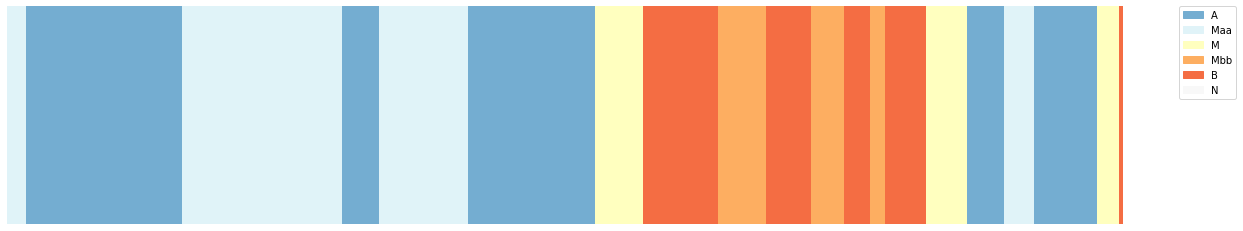

In [11]:
chrom = 'chr19'
annotation_type = 'HMM3P'
start, end = 600, 900
plot_track(hmm_track, chrom, start, end, annotation_type, pallete)

In [12]:
def plotmap(mat, hmm_track, start1, end1, start2, end2, chrom, annotation_type):
    fig= plt.figure(figsize = (10, 10))
        

    
    y_sig = hmm_track[hmm_track.chrom == chrom][hmm].values
    y_sig_max= np.nanmax(y_sig)

    gs = gridspec.GridSpec(20, 20, wspace=2, hspace=2)

    ax0= plt.subplot(gs[2:, 0:2])

    mat_c = track_to_mat(hmm_track, chrom, start2, end2, annotation_type, pallete, horizontal=False)
    ax0.matshow(mat_c,cmap=matplotlib.colors.ListedColormap(cmap), vmin=0, vmax=5, aspect='auto')
    ax0.axis('off')
        
    ax0.margins(0)
    ax0.xaxis.tick_top()
    ax0.yaxis.tick_right()
    plt.yticks(rotation=90)




    ax1= plt.subplot(gs[0:2, 2:])
    mat_c = track_to_mat(hmm_track, chrom, start1, end1, annotation_type, pallete, horizontal=True)
    ax1.matshow(mat_c,cmap=matplotlib.colors.ListedColormap(cmap), vmin=0, vmax=5, aspect='auto')
    ax1.axis('off')
    ax1.margins(0)
    ax1.set_xlabel('Position along Chr19 (100Kb)')


    ax2 = plt.subplot(gs[2:, 2:])
    ax2.matshow(np.log(mat[start2:end2, start1:end1] + 5e-6), cmap = 'YlOrRd', aspect='auto', interpolation ='none')

    if hmm:
        vlines = (np.where(np.abs(np.diff(y_sig[start1:end1]))>0)[0]+1)
        hlines = (np.where(np.abs(np.diff(y_sig[start2:end2]))>0)[0]+1)
        ax2.vlines(vlines, ymin=0, ymax=(end2-start2), colors='black', linestyles='dotted')
        ax2.hlines(hlines, xmin=0, xmax=(end2-start2), colors='black', linestyles= 'dotted')
    plt.xlim([0, (end2-start2)])
    plt.ylim([(end1-start1), 0])
    ax2.axis('off')

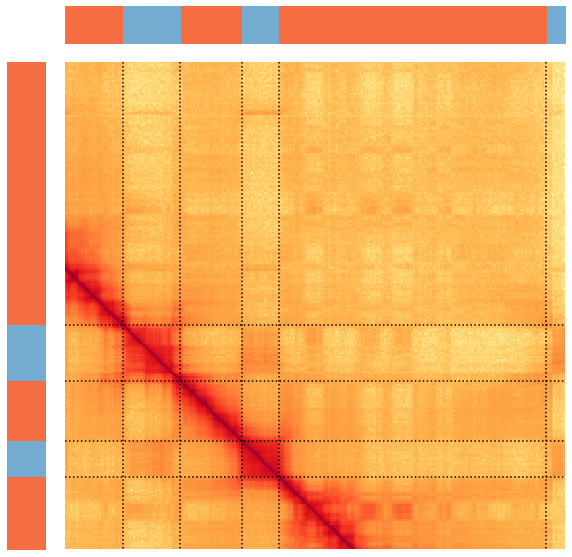

In [13]:
%matplotlib inline
chrom = 'chr19'
hmm= 'binary'

start1, end1 = 140, 400
start2, end2 = 30, 290
plotmap(chr19_mat, hmm_track, start1, end1, start2, end2, chrom, hmm)

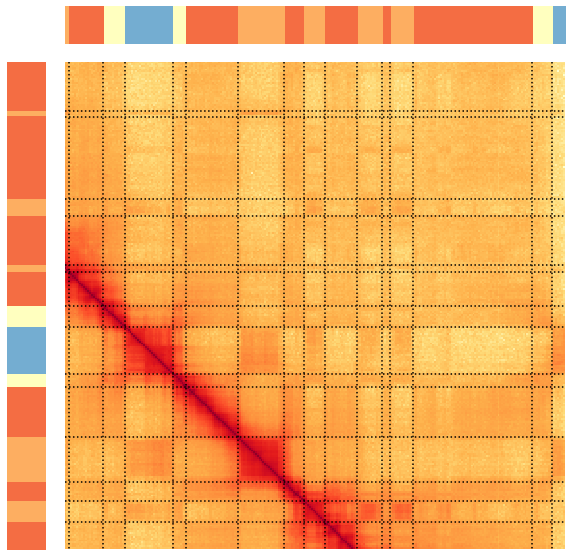

In [14]:
chrom = 'chr19'
hmm= 'HMM3P'

start1, end1 = 140, 400
start2, end2 = 30, 290
plotmap(chr19_mat, hmm_track, start1, end1, start2, end2, chrom, hmm)

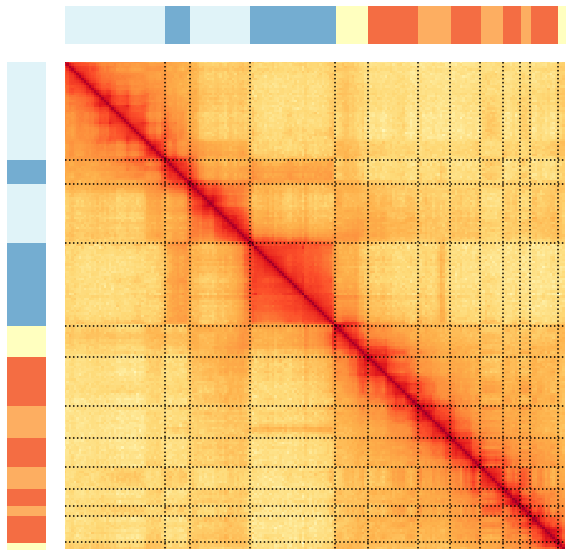

In [15]:
%matplotlib inline
chrom = 'chr19'
hmm= 'HMM3P'

start1, end1 = 650, 850
start2, end2 = 650, 850
plotmap(chr19_mat, hmm_track, start1, end1, start2, end2, chrom, hmm)

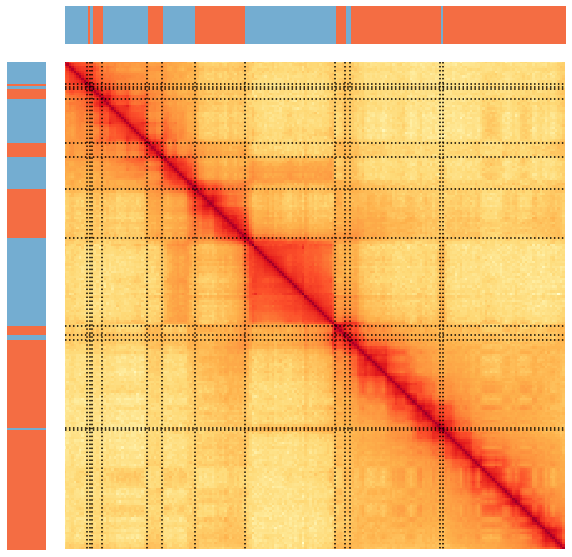

In [16]:
%matplotlib inline
chrom = 'chr19'
hmm= 'binary'

start1, end1 = 650, 850
start2, end2 = 650, 850
plotmap(chr19_mat, hmm_track, start1, end1, start2, end2, chrom, hmm)